# Model training using Mcfly AutoML on the ALFA dataset 

ALFA: A dataset for uav fault and anomaly detection

Reference:

Keipour, A., Mousaei, M., & Scherer, S. (2021). Alfa: A dataset for uav fault and anomaly detection. The International Journal of Robotics Research, 40(2-3), 515-520.

Dataset source: 

https://kilthub.cmu.edu/articles/dataset/ALFA_A_Dataset_for_UAV_Fault_and_Anomaly_Detection/12707963

## Dataset loading

In [19]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
from sktime.datatypes import convert_to
from timeit import default_timer as timer
from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
X, y = load_from_tsfile("data/alfa-uav-fault-detection.ts", return_y=True, return_data_type="numpy3D")

X.shape, y.shape

((2792, 17, 40), (2792,))

In [3]:
X = np.swapaxes(X, 1, 2)
X.shape

(2792, 40, 17)

In [4]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(2792, 2)

In [5]:
X, y = shuffle(X, y, random_state=42)
X.shape, y.shape

((2792, 40, 17), (2792, 2))

### Data splitting into training, validation and test subsets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.20, random_state=42, 
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1786, 40, 17) (447, 40, 17) (559, 40, 17)
(1786, 2) (447, 2) (559, 2)


In [9]:
print("y_train:", Counter(np.argmax(y_train, axis=1)))
print("y_val:", Counter(np.argmax(y_val, axis=1)))
print("y_test:", Counter(np.argmax(y_test, axis=1)))

y_train: Counter({0: 1660, 1: 126})
y_val: Counter({0: 416, 1: 31})
y_test: Counter({0: 520, 1: 39})


## Model training

### Class weights calculation

In [10]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)                                                    
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

{0: 0.5377503852080123, 1: 7.122448979591836}

### Classification model training

In [11]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join("data/models", file_name)
model_path = os.path.join("data/models")

# metric = AUC(curve="PR", name="pr_auc", )
metric = "accuracy"

models = generate_models(
    X_train.shape, 
    y_train.shape[1],
    number_of_models=5,
    model_types=['CNN', 'ResNet', 'InceptionTime'],
    metrics=[metric]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=int(X_train.shape[0] / 2),
    class_weight=class_weights
)

Set maximum kernel size for InceptionTime models to number of timesteps.
Set maximum kernel size for InceptionTime models to number of timesteps.
Generated models will be trained on subset of the data (subset size: 893).
Training model 0 CNN
Epoch 1/30
45/45 [==============================] - 7s 50ms/step - loss: 3.7711 - accuracy: 0.6809 - val_loss: 3.7946 - val_accuracy: 0.5861
Epoch 2/30
45/45 [==============================] - 1s 23ms/step - loss: 3.1633 - accuracy: 0.8690 - val_loss: 3.2325 - val_accuracy: 0.8031
Epoch 3/30
45/45 [==============================] - 1s 24ms/step - loss: 2.7025 - accuracy: 0.9227 - val_loss: 2.7772 - val_accuracy: 0.9530
Epoch 4/30
45/45 [==============================] - 1s 24ms/step - loss: 2.3379 - accuracy: 0.9406 - val_loss: 2.4733 - val_accuracy: 0.9508
Epoch 5/30
45/45 [==============================] - 1s 24ms/step - loss: 2.0510 - accuracy: 0.9552 - val_loss: 2.2056 - val_accuracy: 0.9597
Epoch 6/30
45/45 [==============================] - 1

45/45 [==============================] - 2s 53ms/step - loss: 5.0573 - accuracy: 0.6383 - val_loss: 135.3590 - val_accuracy: 0.9284
Epoch 8: early stopping
Training model 4 InceptionTime
Epoch 1/30
45/45 [==============================] - 7s 82ms/step - loss: 3.6554 - accuracy: 0.6663 - val_loss: 111.4720 - val_accuracy: 0.4340
Epoch 2/30
45/45 [==============================] - 2s 39ms/step - loss: 0.1384 - accuracy: 0.9384 - val_loss: 4.1122 - val_accuracy: 0.6779
Epoch 3/30
45/45 [==============================] - 2s 39ms/step - loss: 0.1407 - accuracy: 0.9642 - val_loss: 1.9872 - val_accuracy: 0.8904
Epoch 4/30
45/45 [==============================] - 2s 39ms/step - loss: 0.1063 - accuracy: 0.9530 - val_loss: 0.8919 - val_accuracy: 0.8837
Epoch 5/30
45/45 [==============================] - 2s 40ms/step - loss: 0.0650 - accuracy: 0.9765 - val_loss: 0.6396 - val_accuracy: 0.8680
Epoch 6/30
45/45 [==============================] - 2s 38ms/step - loss: 0.0845 - accuracy: 0.9675 - val_l

In [12]:
best_model_index = np.argmax(val_metrics["accuracy"])
best_model, best_params, best_model_type = models[best_model_index]

print("Best model type:", best_model_type)

Best model type: InceptionTime


### Model training history plots

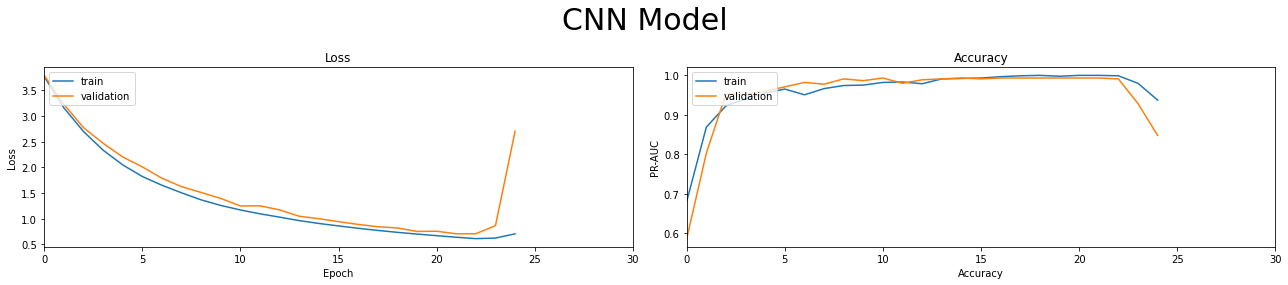

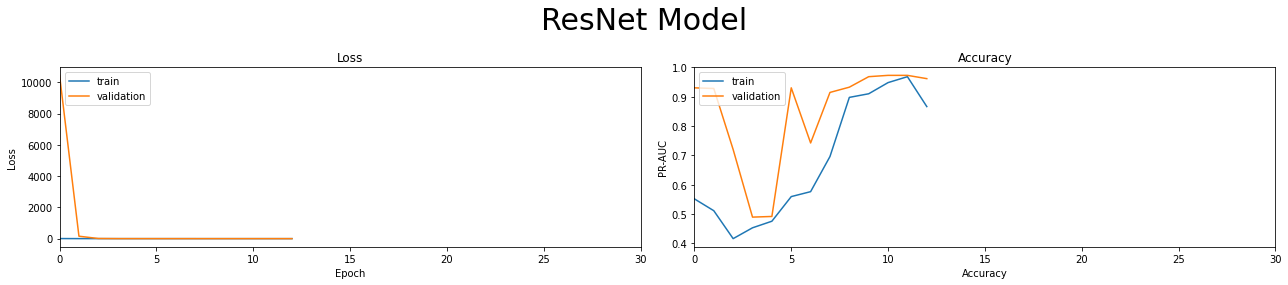

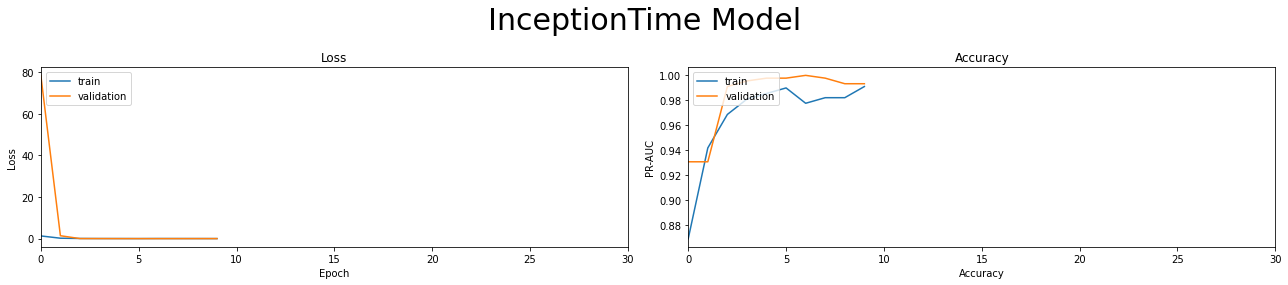

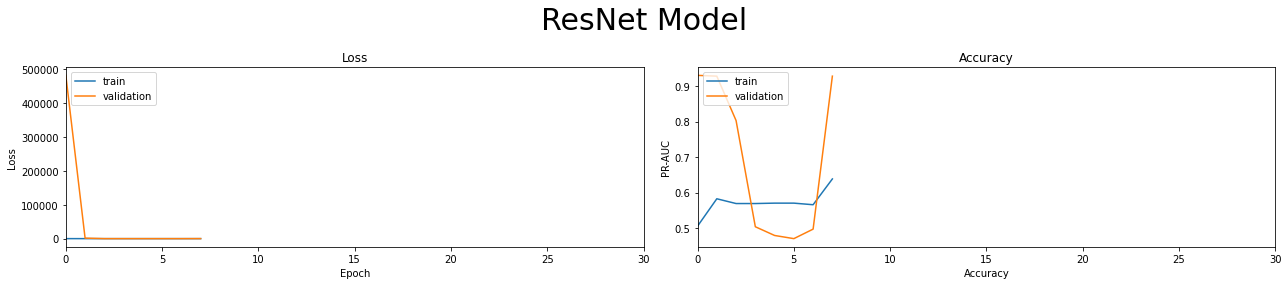

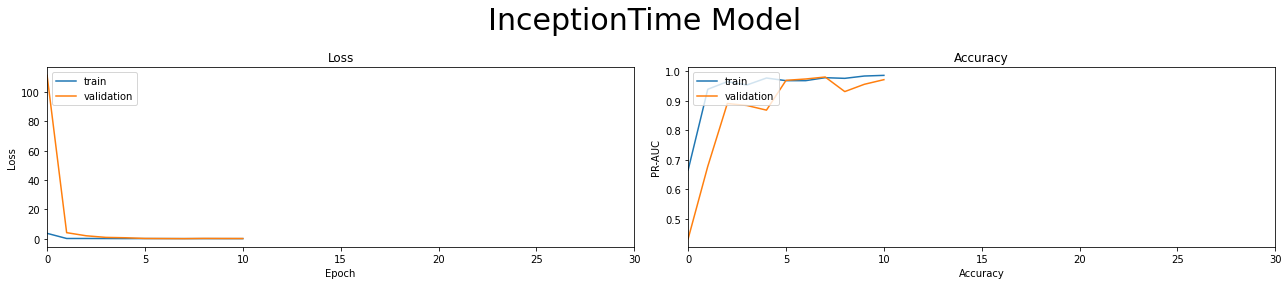

In [14]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim([0, 30])
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history[i].history['accuracy'])
    ax2.plot(history[i].history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('PR-AUC')
    ax2.set_xlabel('Accuracy')
    ax2.set_xlim([0, 30])
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

### Train the best model on the full training dataset

In [15]:
%%time

history = best_model.fit(
    X_train, 
    y_train,
    epochs=20, 
    validation_data=(X_val, y_val),
)

Epoch 1/20
56/56 [==============================] - 8s 86ms/step - loss: 0.0221 - accuracy: 0.9966 - val_loss: 0.0235 - val_accuracy: 0.9955
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 0.0117 - accuracy: 0.9944 - val_loss: 0.0106 - val_accuracy: 0.9955
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 0.0103 - accuracy: 0.9966 - val_loss: 0.0077 - val_accuracy: 0.9955
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0120 - val_accuracy: 0.9955
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.0140 - val_accuracy: 0.9955
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9955
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0131 - val_accuracy: 0.9955
Epoch 8/20
56

### The best model evaluation

In [16]:
y_pred = best_model.predict(X_test, batch_size=1)

559/559 [==============================] - 5s 8ms/step


In [17]:
print(f"Classification report fot the {best_model_type} model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1), 
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

Classification report fot the InceptionTime model:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       520
           1     1.0000    1.0000    1.0000        39

    accuracy                         1.0000       559
   macro avg     1.0000    1.0000    1.0000       559
weighted avg     1.0000    1.0000    1.0000       559



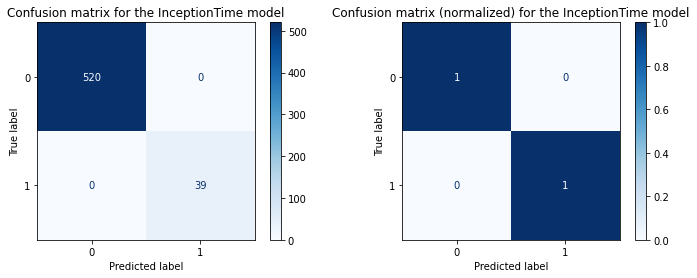

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)
ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)
ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")

plt.show()